# Tutorial 3 - Dynamask

In this tutorial we we create a Dynamask explainer object and use it to explain a test record. The explainer is then saved to disk and can be given to someone else to view in the [Interpretability Suite App](https://vanderschaarlab-demo-interpretabi-interpretability-suite-1uteyn.streamlit.app/).

We will be explaining the predictions of pytorch convolutional neural net that we have trained and saved separately on an engine noise dataset from IEEE World Congress on Computational Intelligence, 2008. The Interpretability.models module provides a a pytorch model for this that is compatible with trained models `state_dict`s available on the Google Drive link below.

### Import the relevant modules

In [1]:
# Standard
import os
import pathlib

# Third Party
import numpy as np
import torch

# Intperpretability
from interpretability.models.recurrent_neural_net import ConvNet
from interpretability.interpretability_models import dynamask_explainer
from interpretability.interpretability_models.utils import io

### Load the data 
Load the data and split it into the train and the test examples we will explain. This cell will download the data from the `root_url` and save it to a subdirectory in the folder this notebook is being run.

In [2]:
# LOADS
def load_forda_data():
    def readucr(filename):
        data = np.loadtxt(filename, delimiter="\t")
        y = data[:, 0]
        x = data[:, 1:]
        return x, y.astype(int)

    root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

    x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
    x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    idx = np.random.permutation(len(x_train))
    x_train = x_train[idx]
    y_train = y_train[idx]

    y_train[y_train == -1] = 0
    y_test[y_test == -1] = 0

    return x_train, y_train, x_test, y_test


X_train, y_train, X_explain, y_explain = load_forda_data()

### Download the trained model from Google Drive

You could train your own model using the ConvNet class and load it here, but we have trained one already.

Download the model using this link: https://drive.google.com/file/d/173vniHegUSGmdC6fKCLupynRoxEdz9Ko/view?usp=sharing and save it in a location matching the path `TRAINED_MODEL_STATE_PATH` below (This is the same model as in "Tutorial_02_implement_simplex_time_series", so if you have already done so, there is no reason to download it again). The default location is the `"resources/saved_models"` folder inside the root Interpretability directory.


### Load the model

In [3]:
## Load the model
model = ConvNet()

def load_trained_model(model, trained_model_state_path, device='cpu'):
    model.load_state_dict(torch.load(trained_model_state_path, map_location=torch.device(device)))
    model.eval()
    return model

DEVICE = "cpu"

root_path = pathlib.Path.cwd().parents[0]
saved_models_path = root_path / "resources/saved_models"
TRAINED_MODEL_STATE_PATH = saved_models_path / "model_cv1_2.pth"
model = load_trained_model(model, TRAINED_MODEL_STATE_PATH, device=DEVICE)

### Initialize Dynamask
Initialize the explainer object by passing the predictive model, the perturbation method to use, and whether or not to use a `Mask` or `GroupMask`.

In [4]:
available_perturbation_method = [
    "fade_moving_average",
    "gaussian_blur",
    "fade_moving_average_window",
    "fade_moving_average_past_window",
    "fade_reference",
]

my_explainer = dynamask_explainer.DynamaskExplainer(
    model, available_perturbation_method[1], group=False
)

### Fit the explainer

Fit the explainer on the training data. This makes explanations of the test data available in the subsequent step.

In [5]:
available_loss_functions = [
    "cross_entropy",
    "log_loss",
    "log_loss_target",
    "mse",
]

explain_id = 1

my_explainer.fit(
    explain_id,
    X_train,
    loss_function=available_loss_functions[0],
    target=y_train[explain_id],
    area_list=np.arange(0.1, 0.5, 0.1),
)
feature_num, time_step_num = X_train[0].shape

Fitting Dynamask


/home/rob/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


The optimization finished: error = 3.17e-05 ; size regulator = 1.49e-07 ; time regulator = 0.00224 ; time elapsed = 3.72 s



### Get the explanation
Get the explanation for the record selected above. We can also choose whether to smooth the mask or not.

In [6]:
print(
    my_explainer.explain(
        # ids_feature=[i for i in range(5)],
        # ids_time=[i for i in range(5)],
        smooth=False,
        get_mask_from_group_method="extremal",
        extremal_mask_threshold=0.01,
    ).feature_importances
)

   0         1    2    3        4    5    6        7    8    9    ...  490  \
0  0.0  0.002335  0.0  0.0  0.00217  0.0  0.0  0.00218  0.0  0.0  ...  1.0   

   491  492  493  494  495  496  497  498  499  
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[1 rows x 500 columns]


### Plot the explanation
Plot the feature importance over time. This produces an image as a png.

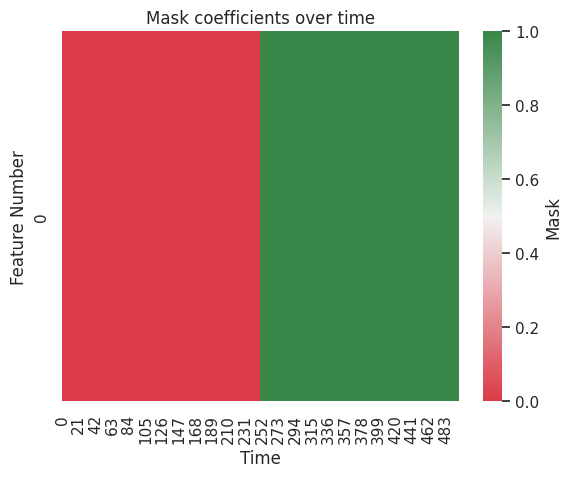

In [7]:
my_explainer.summary_plot()

### Save the explainer to file
This file can now be uploaded to the [Interpretability Suite App](https://vanderschaarlab-demo-interpretabi-interpretability-suite-1uteyn.streamlit.app/). This provides a non-programtic interface with which to view the various explanations, allowing you to send the explainer to a colleague who is less fluent in python.

In [8]:
io.save_explainer(
    my_explainer, os.path.abspath("my_new_forda_conv_dynamask_explainer.p")
)

Saving explainer to: /home/rob/Documents/projects/Interpretability/Notebooks/my_new_forda_conv_dynamask_explainer.p
